<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 31 January 2017</td>
<td style="text-align: right;"><a href="https://www.github.com/rhyswhitley/fire_limitation">github.com/rhyswhitley/fire_limitation</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of a global fire limitation model using Bayesian inference</h1>
<h2>Part 2: Bayesian inference</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>2 </sup>Ioannis Bistinas, 
<sup>3, 4 </sup>Chantelle Burton, 
<sup>1 </sup>Tobias Marthews, 
<sup>5 </sup>Rhys Whitley
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Vrije Universiteit Amsterdam, Faculty of Earth and Life Sciences, Amsterdam, Netherlands
<br>
<sup>3 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>4 </sup>Geography, University of Exeter, Exeter, United Kingdom
<br>
<sup>5 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of a global fire model (defined below). The model is driven by a number of covariates (X<sub>i=1, 2, ... M</sub>) that describe: cropland, pasture and urban area footprints; frequency of lightening ignitions, population density, net primary productivity (NPP) and <i>Alpha</i>, a proxy measure of available soil moisture in the root zone. The model attempts to predict the impact of fire through burnt area and is thus the model target (Y).
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### Model description
The model considers percentage of burnt area to be the joint product of a set of conditions that modulate fire through fuel load, ignitions, moisture and supression. Each function assumes some equilibrium point that desribes the optimal conditions for fire, that may be proportionally modified through some empirical relationship. These are briefly outlined below for the sake of comprehension in this notebook, but can be referred to in more detail in the model protocol located in the docs/ folder (<a href='file:///localhost/../docs/Model_description.pdf'>model protocol</a>).

\begin{eqnarray}
    F_{burn} &=& \prod^{4}_{i=1}S_i(x) \\[1em]
    S_1 &=& S(x_{fuel}) \\[0.5em]
    S_2 &=& S(x_{moist}) \\[0.5em]
    S_3 &=& 1.0 - S(x_{ignite}) \\[0.5em]
    S_4 &=& 1.0 - S(x_{suppr})
\end{eqnarray}

<a style="color: red;">Doug, is subtracting functions 3 and 4 from 1.0 necessary? If you want the sigmoid to go the other way the parameters just need to change sign; this would be found in the optimisation anyway, so I've dropped them.</a> Each of the above 4 functions describe some measure fire conditions, and are described by a sigmoid:

\begin{equation}
    S(x_{i=1\ldots 4}) = \frac{1}{1 + \exp\{-b\cdot(x_i-a)\}}
\end{equation}

Sigmoids $2\ldots 4$ describe an aggregation of other climate and land-use covariates; the fuel load sigmoid considers only NPP and therefore has no hyper-parameters. Because these other sigmoids are influenced by an aggregation of different drivers, $x_{2\ldots 4}$ is influenced in turn by different sets of hyper-parameters; these are now described below.  

#### Fuel load covariate (no hyper-parameters)
\begin{equation}
    x_{fuel} = NPP 
\end{equation}

#### Moisture covariate
\begin{equation}
    x_{moist} = \frac{\alpha + k_m\cdot p_{atm}}{1 + k_m}
\end{equation}
<a style="color: red">What is p<sub>atm</sub>? I couldn't find how this relates to the data you sent me...</a>

#### Ignition covariate 
\begin{equation}
    x_{ignite} = F_L\cdot\min(1.0,\space 0.0408\cdot F_L^{-0.4180}) + k_p\cdot A_{pasture} + k_{d1}\cdot\rho_{population}
\end{equation}

<a style="color: red">F<sub>L</sub>=0.0 is not possible, as 0.0 can't have a negative signed exponent; have I got this equation right?</a>


#### Supression covariate 
\begin{equation}
    x_{supress} = A_{urban} + k_C\cdot A_{Crop} + k_{d2}\cdot\rho_{population} 
\end{equation}

This leaves 12 free parameters that need to be optimised against observations of burnt area.  

### Load libraries

In [1]:
import os
import numpy as np
import pandas as pd

import pymc3 as pm3 
from pymc3.backends import SQLite
from scipy import optimize
from theano import tensor as tt

import matplotlib.pyplot as plt

# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

## 2.1 Fire limitation model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [2]:
def lightning(flash):
    """
    Transform flashes to some lightning measure 
    """
    return flash*min(1.0, 0.0408*flash**(-0.4180))

def fuel_load(NPP):
    """
    Definition to describe fuel load: while return the input; capability to be modified later.
    """
    return NPP

def moisture(alpha, p_atm=0, kp=0):
    """
    Definition to describe moisture: currently equals alpha; capability to be modified later.
    """
    return (alpha + kp*p_atm)/(1.0 + kp) 

def ignition(lightning, pasture_area, pop_density, kp, kd1):
    """
    Definition for the measure of ignition
    """
    return lightning + kp*pasture_area + kd1*pop_density

def supression(urban_area, crop_area, pop_density, kc, kd2):
    """
    Definition for the measure of fire supression
    """
    return urban_area + kc*crop_area + kd2*pop_density

def tt_sigmoid(x, a, b):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 - tt.exp(-b*(x - a)))

## 2.2 Import data

Load data and do any necessary transformation needed for the Bayesian modelling framework. For testing purposes I've limited the number of rows I'm importing (here about 100K). If you plan to do the full dataset, then delete the `nrows` variabe in the cell below. 

In [5]:
DATAPATH = os.path.expanduser("../data/globfire.csv.gz")

fd = pd.read_csv(DATAPATH, nrows=1e6)

Transform the flash measures to a measure of lightning ignition. Probably better to redo column names in previous notebook to save confusion.

In [6]:
fd['x_light'] = [lightning(x) if x > 0 else 0 for x in fd['lightning_ignitions'].values]

Do a sanity check to make sure our data has imported correctly.

In [8]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
alpha                  1000000 non-null float64
cropland               1000000 non-null float64
fire                   1000000 non-null float64
lightning_ignitions    1000000 non-null float64
NPP                    1000000 non-null float64
pasture                1000000 non-null float64
population_density     1000000 non-null float64
urban_area             1000000 non-null float64
x_light                1000000 non-null float64
dtypes: float64(9)
memory usage: 68.7 MB


## 2.3 Baysian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the reponse of our _proposed understanding_ of this system as it varies with $X$.

### 2.3.1 Prior definitions
Because I have no idea what the uncertainty on the hyper parameters should look like (beyond $\beta> 0$), I've set them all as uniform. Some of them can possibly be describe as exponential or half-normal, due to the physical nature of $\beta$, but we can play around with that later.

\begin{eqnarray}
    P(\beta) &=& \prod_{i=1}^{4}P(a_i)\prod_{i=1}^{4}P(b_i)\cdot P(\sigma)\cdot P(k_c)P(k_p)P(k_{d,1})P(k_{d,2}) \\[1.5em]
    P(a) = P(b) = P(\sigma) &=& \mathcal{N}(0, 1) \\[1em]
    P(k_c) = P(k_p) = P(k_{d,1}) = P(k_{d,2}) &=& \mathcal{U}(\beta_{\min}, \beta_{\max}) \\[1.5em]
\end{eqnarray}

I'm not totally sure about the maths above being right, but it's just to show that _full_ prior is normal. Important, because we'll also describe the error (likelihood) as normal, such that the posterior is therefore normal (conjugate); i.e. $\mathcal{N}\times\mathcal{N}=\mathcal{N}$ (expansion happens in the mean of the exponent). 

Back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `fire_error` as that is what we are trying to Quantify.



In [9]:
with pm3.Model() as fire_error:
    
# first for the sigmoids (the 4's at the end state that I want 4 of them)
    a_s4 = pm3.Normal('sig_a', mu=0, sd=1, shape=4)
    b_s4 = pm3.Normal('sig_b', mu=0, sd=1, shape=4)
    
# now for the hyper-parameters that describe the independent fire condition covariates

#    kc = pm3.HalfNormal('kc', mu=0, sd=5)
#    kp = pm3.HalfNormal('kp', mu=0, sd=5)
#    kd1 = pm3.HalfNormal('kd1', mu=0, sd=5)
#    kd2 = pm3.HalfNormal('kd2', mu=0, sd=5)

    kc = pm3.Uniform('kc', 0, 1e3)
    kp = pm3.Uniform('kp', 0, 1e3)
    kd1 = pm3.Uniform('kd1', 0, 1e3)
    kd2 = pm3.Uniform('kd2', 0, 1e3)
    
# describe the standard deviation in the error term
    sigma = pm3.HalfNormal('sigma', sd=1)

### 2.3.2 Likelihood definition

For the sake of simplicity (and because I don't really know any better), we define the model error as normally distributed (i.i.d.) although it most likely isn't. We could make this more complicated later by defining the error as heteroscedastic, but I wouldn't bother with that until we have some idea of the convergence. We're describing the error (observations minus model predictions) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(F_{burn}, \sigma) \\[1em]
    \mathcal{N}(F_{burn}, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - F_{burn, i}}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $y_i$ is a set of observations we're attempting to optimise on. Below is the code that describes the above:

In [10]:
with fire_error:
    
    # transform hyper-covariates 
    x_1 = fd["NPP"].values
    
    x_2 = fd["alpha"].values
    
    x_3 = ignition(fd["x_light"].values, \
                   fd["pasture"].values, \
                   fd["population_density"].values, \
                   kp, kd1)
    
    x_4 = supression(fd["urban_area"].values, \
                     fd["cropland"].values, \
                     fd["population_density"].values, \
                     kc, kd2)
    
    # list of primary covariates
    xs = [x_1, x_2, x_3, x_4]
    Nx = len(xs)
    
    # burnt area is assumed to be the product of the 4 sigmoids
    prediction = np.product([tt_sigmoid(xs[i], a_s4[i], b_s4[i]) for i in range(Nx)])
    
    # calculate the error between observed and predicted burnt area
    error = pm3.Normal('error', mu=prediction, sd=sigma, observed=fd['fire'].values)

### 2.3.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out - but TBH it doesn't matter if we're getting a reasonable convergence.

In [11]:
with fire_error:
    
    # help the sampling out by quickly finding an optimal start position
    start = pm3.find_MAP(model=fire_error.model, fmin=optimize.fmin_powell)
    
    # set the step-method (criteria algorithm for moving around information space)
    step = pm3.Metropolis()
    
    # save our sampling to disk so we can access it later
    db_save = SQLite('../data/firemodel_trace.db')
    
    # do the sampling
    mcmc_traces = pm3.sample(2e3, step=step, start=start, njobs=-1, trace=db_save)

Optimization terminated successfully.
         Current function value: -2455342.946910
         Iterations: 3
         Function evaluations: 496


100%|██████████| 2000/2000.0 [19:00<00:00,  1.80it/s]


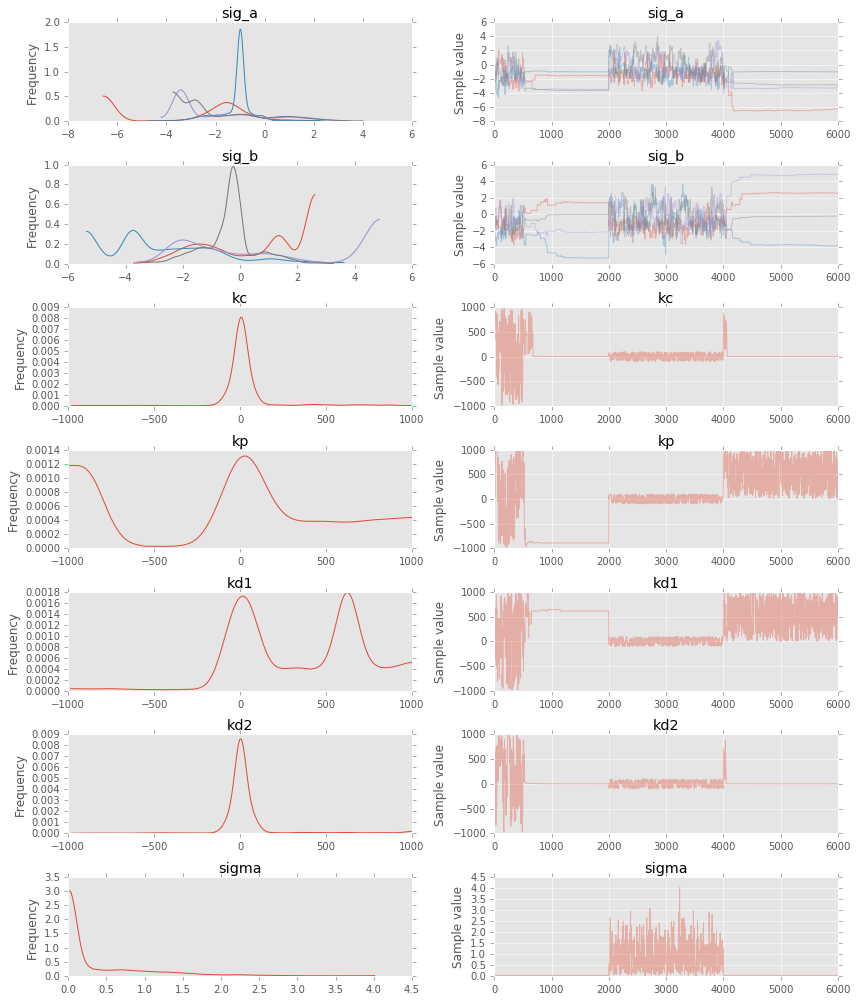

In [12]:
pm3.traceplot(mcmc_traces);

In [88]:
type(mcmc_traces)

pymc3.backends.base.MultiTrace